In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap
import os
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import ast
from collections import Counter

In [2]:
# !!! Modify this to match the name of the csv file of the patients you generated
file_path = "llm_patients_040725.csv"

In [3]:
# !!! Modify this to specify what folder you would like your plots to go into
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# =============================================================================
# Hard-coded Demographic Distributions
# =============================================================================

""" This data is the same as the demographic distributions from the llm_patient_creator.ipynb file. """
# split distributions to a .py file?

SEX_WEIGHTS = [0.49, 0.51]
SEX_LABELS = ["Male", "Female"]

# Age distribution (averaged for men & women).
AGE_WEIGHTS_MEN = [0.2979, 0.1916, 0.1557, 0.2266, 0.1282]
AGE_WEIGHTS_WOMEN = [0.2861, 0.1683, 0.1483, 0.2343, 0.1630]

AGE_ORDER = ["18-25", "26-35", "36-45", "46-60", "60+"]

# Relationship status percentages by age group: (18-25, 26-35, 36-45, 46-60, 60+)
RELATIONSHIP_STATUS_DISTRIBUTIONS = [
    [69.26, 23.09,  7.40,  0.25,  0.00],  # 18-25
    [31.73, 10.58, 55.35,  2.15,  0.20],  # 26-35
    [10.88,  3.63, 76.00,  8.15,  1.35],  # 36-45
    [ 9.00,  3.00, 68.33, 15.33,  8.17],  # 46-60
    [11.25,  3.75, 54.17,  8.83, 33.50],  # 60+
]

RELATIONSHIP_ORDER = ["Single", "Long-term relationship",
                          "Married/Common-Law", "Divorced/Separated", "Widowded"]

# Probabilities of being "in a family" & "with children," by 4 age bins (0-24, 25-34, 35-44, 45-54).
IN_FAMILY = [
    [0.0756, 0.0701],  # female, male (0-24)
    [0.5102, 0.4765],  # female, male (25-34)
    [0.8340, 0.8178],  # female, male (35-44)
    [0.8426, 0.8557],  # female, male (45+)
]
WITH_CHILDREN = [
    [0.6997, 0.3003],  # yes, no  (0-24)
    [0.5193, 0.4807],  # yes, no  (25-34)
    [0.2056, 0.7944],  # yes, no  (35-44)
    [0.1771, 0.8229],  # yes, no  (45+)
]

DISABILITY_PROBABILITY_TYPES = [
        38.6, 61.8, 27.4, 20.7, 18.2,
        39.2, 40.3, 20.7, 18.4, 5.7
    ]

DISABILITY_CATEGORIES = [
        "Mental-health related", "Pain-related", "Seeing",
        "Learning", "Memory", "Mobility", "Flexibility",
        "Hearing", "Dexterity", "Developmental"
    ]

ETHNICITY_CATEGORIES = {
    "Indigenous": [
        "English - Canada", "English - United States",
        "English - United Kingdom", "English - Ireland"
    ],
    "Middle Eastern": ["Persian - Iran", "Hebrew - Israel"],
    "European": [
        "Czech - Czech Republic", "Danish - Denmark", "German - Austria",
        "German - Switzerland", "German - Germany", "Greek - Greece",
        "Spanish - Spain", "Finnish - Finland", "French - Canada",
        "French - Switzerland", "French - France", "Croatian - Croatia",
        "Hungarian - Hungary", "Armenian - Armenia", "Italian - Italy",
        "Dutch - Belgium", "Dutch - Netherlands", "Norwegian - Norway",
        "Polish - Poland", "Portuguese - Portugal", "Romanian - Romania",
        "Russian - Russia", "Slovak - Slovakia", "Swedish - Sweden",
        "Ukrainian - Ukraine"
    ],
    "East Asian": [
        "Japanese - Japan", "Korean - South Korea",
        "Chinese - China", "Chinese - Taiwan"
    ],
    "South Asian": [
        "English - India", "Hindi - India", "Nepali - Nepal",
        "Tamil - India", "Bengali - Bangladesh", "English - Bangladesh",
        "Georgian - Georgia", "Azerbaijani - Azerbaijan"
    ],
    "Southeast Asian": [
        "English - Malaysia", "English - Philippines", "Filipino - Philippines",
        "Indonesian - Indonesia", "Thai - Thailand", "Tagalog - Philippines",
        "Vietnamese - Vietnam"
    ],
    "Latin American": [
        "Spanish - Argentina", "Spanish - Chile", "Spanish - Colombia",
        "Spanish - Mexico", "Portuguese - Brazil"
    ],
    "African": ["Zulu - South Africa"],
    "Other": ["English - Australia", "English - New Zealand"],
}

In [5]:
# =============================================================================
# Basic Load and Preprocessing
# =============================================================================

def load_data(filepath: str) -> pd.DataFrame:
    """Load the CSV file (pipe-delimited)."""
    return pd.read_csv(filepath, delimiter="|")


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all data-cleaning steps in one place:
      - Rename columns
      - Map relationships
      - Convert columns to categories
      - Assign extended age groups
      - Convert 'Children to yes/no
      - Create 'Ethnicity_Category'
    """
    # Work on a copy to avoid modifying original
    df = df.copy()

    # Rename columns
    df.rename(columns={
        "Relationship Status": "Relationship_Status",
        "Children": "Has_Children",
    }, inplace=True)

    # Simplify relationship statuses
    relationship_mapping = {
        "Common-Law": "Married/Common-Law",
        "Married": "Married/Common-Law",
        "Divorced": "Divorced/Separated",
        "Separated": "Divorced/Separated"
    }
    df["Relationship_Status"] = df["Relationship_Status"].replace(relationship_mapping)

    # Convert certain columns to categorical
    df["Sex"] = df["Sex"].astype("category")
    df["Relationship_Status"] = df["Relationship_Status"].astype("category")

    # Convert "Has_Children" to yes/no
    df["Has_Children"] = df["Has_Children"].apply(
        lambda x: "Yes" if x != 0 else "No"
    )

    # Create extended age groups
    df["Age_Group"] = df["Age"].apply(assign_age_group_extended)

    # Categorize ethnicity
    df["Ethnicity_Category"] = df["Ethnicity"].apply(categorize_ethnicity)
    df["Ethnicity_Category"] = df["Ethnicity_Category"].astype("category")

    return df

In [6]:
# =============================================================================
# Helper Functions
# =============================================================================

def assign_age_group_extended(age: float) -> str:
    """
    Assign an extended age group (18-25, 26-35, 36-45, 46-60, 60+).
    """
    if age < 25:
        return "18-25"
    elif age < 36:
        return "26-35"
    elif age < 46:
        return "36-45"
    elif age < 61:
        return "46-60"
    else:
        return "60+"


def categorize_ethnicity(ethnicity: str) -> str:
    """Map ethnicity strings into broad categories or return 'Uncategorized'."""
    for category, values in ETHNICITY_CATEGORIES.items():
        if ethnicity in values:
            return category
    return "Uncategorized"


def compute_standard_deviations(values: np.ndarray, sample_size: int = 1000) -> list[float]:
    """
    Compute standard deviations for binomial proportions:
      variance = n * p * (1 - p)
      std = sqrt(variance) / n
    """
    stds = []
    for val in values:
        variance = sample_size * val * (1 - val)
        stds.append(np.sqrt(variance) / sample_size)
    return stds

def compute_expected_disability(row: pd.Series) -> pd.Series:
    """
    Hard-coded probability of being disabled by (sex, age),
    then distribute among 10 disability types.
    """
    # # Determine sex & age
    # sex = row.get("Gender", "Male")
    # age = row.get("Age", 30)
    # sex_idx = 0 if sex == "Male" else 1

    # if age < 25:
    #     age_idx = 0
    # elif age < 65:
    #     age_idx = 1
    # else:
    #     age_idx = 2

    # # Hard-coded disability probability by sex/age
    # if sex_idx == 0:  # male
    #     disability_probability_total = [0.158, 0.211, 0.389]
    # else:  # female
    #     disability_probability_total = [0.247, 0.269, 0.418]

    # p_disabled = disability_probability_total[age_idx]

    # Hard-coded distribution across 10 types
    s = 38.6 + 61.8 + 27.4 + 20.7 + 18.2 + 39.2 + 40.3 + 20.7 + 18.4 + 5.7
    DISABILITY_PROBABILITY_TYPES_NORM = [
        38.6/s, 61.8/s, 27.4/s, 20.7/s, 18.2/s,
        39.2/s, 40.3/s, 20.7/s, 18.4/s, 5.7/s
    ]
    fraction = []
    for i in DISABILITY_PROBABILITY_TYPES:
        fraction.append(i/100)
        
    expected_values = {
        cat: p_type
        for cat, p_type in zip(DISABILITY_CATEGORIES, DISABILITY_PROBABILITY_TYPES_NORM)
    }
    return pd.Series(expected_values)

In [7]:
# =============================================================================
# Plotting Functions
# =============================================================================

def draw_split_diagonal_cells(ax: plt.Axes,
                              observed_arr: np.ndarray,
                              expected_arr: np.ndarray,
                              cmap_obs,
                              cmap_exp,
                              norm_obs,
                              norm_exp,
                              text_size: int = 9) -> None:
    """
    Draw half a cell for observed (upper-left) and half for expected (lower-right),
    each colored by its own colormap & normalization.
    """
    n_rows, n_cols = observed_arr.shape

    for i in range(n_rows):
        for j in range(n_cols):
            # Coordinates for the cell boundaries (each cell is 1x1).
            top_left = (j, i)
            bottom_left = (j, i + 1)
            bottom_right = (j + 1, i + 1)
            top_right = (j + 1, i)

            # Observed triangle (upper-left)
            obs_val = observed_arr[i, j]
            color_obs = cmap_obs(norm_obs(obs_val))
            ax.add_patch(patches.Polygon([top_left, bottom_left, top_right],
                                         facecolor=color_obs,
                                         edgecolor="white"))
            # Expected triangle (lower-right)
            exp_val = expected_arr[i, j]
            color_exp = cmap_exp(norm_exp(exp_val))
            ax.add_patch(patches.Polygon([bottom_left, bottom_right, top_right],
                                         facecolor=color_exp,
                                         edgecolor="white"))

            # Annotations
            ax.text(j + 0.3, i + 0.3, f"{obs_val:.2f}",
                    ha="center", va="center",
                    fontsize=text_size, color="black")

            ax.text(j + 0.7, i + 0.7, f"{exp_val:.2f}",
                    ha="center", va="center",
                    fontsize=text_size, color="black")


def plot_comparison(observed: dict,
                    expected: dict,
                    title: str,
                    chart_type: str = "bar",
                    save_fig: bool = False) -> None:
    """
    Generic function to compare 'observed' vs. 'expected' data in a bar plot.
    Error bars are derived from the 'expected' distribution (binomial assumption).
    """
    categories = list(expected.keys())
    observed_vals = np.array([observed.get(cat, 0) for cat in categories])
    expected_vals = np.array([expected[cat] for cat in categories])

    # Compute standard deviations from the expected distribution
    stds = compute_standard_deviations(expected_vals, sample_size=1000)

    x_positions = np.arange(len(categories))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    if chart_type == "bar":
        ax.bar(x_positions - bar_width/2,
               observed_vals,
               bar_width,
               color = 'blue',
               yerr=stds,
               capsize=5,
               label="Observed")

        ax.bar(x_positions + bar_width/2,
               expected_vals,
               bar_width,
               color = 'red',
               label="Expected")

    # Optionally handle other chart types (e.g., line) here...

    # Wrap x labels if they're too long
    wrapped_labels = [textwrap.fill(cat, width=13) for cat in categories]
    font_size = 14
    ax.set_xticks(x_positions)
    ax.set_xticklabels(wrapped_labels, rotation=90, fontsize=font_size)
    ax.set_ylabel("Fraction", fontsize=font_size)
    ax.set_title(title, fontsize=font_size + 2)
    ax.legend(fontsize=font_size)
    plt.tight_layout()

    if save_fig:
        filename = f"{OUTPUT_DIR}/{title.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Saved: {filename}")

    plt.show()


def plot_split_diagonal_heatmap(observed_df: pd.DataFrame,
                                expected_df: pd.DataFrame,
                                title: str,
                                x_label: str,
                                y_label: str,
                                save_fig: bool = False,
                                filename: str = "split_diagonal.png") -> None:
    """
    Generic function to plot a split-diagonal heatmap comparing observed_df vs. expected_df.
    The dataframes must have the same shape and aligned indices/columns.

    This wraps up:
      - Setting axes limits, ticks, labels
      - Drawing cells via draw_split_diagonal_cells
      - Adding colorbars
      - Saving if requested
    """
    if observed_df.shape != expected_df.shape:
        raise ValueError("observed_df and expected_df must have the same shape.")

    row_labels = observed_df.index.tolist()
    col_labels = observed_df.columns.tolist()

    observed_arr = observed_df.values
    expected_arr = expected_df.values

    # Determine common color scale limits (optional: you could do separate scales)
    min_val = min(observed_arr.min(), expected_arr.min())
    max_val = max(observed_arr.max(), expected_arr.max())

    cmap_obs = plt.get_cmap("Blues")
    cmap_exp = plt.get_cmap("Reds")
    norm_obs = mcolors.Normalize(vmin=min_val, vmax=max_val)
    norm_exp = mcolors.Normalize(vmin=min_val, vmax=max_val)

    n_rows, n_cols = observed_arr.shape
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()

    # Configure tick positions (center of each cell) and labels
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_xticklabels(col_labels, rotation=45, ha="right")
    ax.set_yticklabels(row_labels)

    # Title and axis labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Draw the actual split cells
    draw_split_diagonal_cells(ax,
                              observed_arr,
                              expected_arr,
                              cmap_obs,
                              cmap_exp,
                              norm_obs,
                              norm_exp,
                              text_size=8)

    # Adjust layout for colorbars on the right
    plt.subplots_adjust(right=0.70)

    # Observed colorbar
    cbar_obs_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])
    sm_obs = plt.cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
    sm_obs.set_array([])
    cbar_obs = fig.colorbar(sm_obs, cax=cbar_obs_ax)
    cbar_obs.set_label("Observed", fontsize=10)

    # Expected colorbar
    cbar_exp_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    sm_exp = plt.cm.ScalarMappable(cmap=cmap_exp, norm=norm_exp)
    sm_exp.set_array([])
    cbar_exp = fig.colorbar(sm_exp, cax=cbar_exp_ax)
    cbar_exp.set_label("Expected", fontsize=10)

    if save_fig:
        out_path = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"Saved: {out_path}")

    plt.show()

In [8]:
# =============================================================================
# Main Analysis Flow
# =============================================================================

def run_analysis(df: pd.DataFrame) -> None:
    """
    Run the various analyses (disability, gender distribution,
    age distribution, relationship status, and children) after preprocessing.
    """

    # ==========================================================================
    # DISABILITY BREAKDOWN: OBSERVED VS. EXPECTED (BAR COMPARISON)
    # ==========================================================================

    # 0) Filter to rows where Disability == 'Yes'
    df_yes_disability = df[df["Disabled"] == "Yes"]
    print(df_yes_disability.shape)

    # 1) Parse and flatten the disability type lists
    all_types = []

    for val in df_yes_disability["Disability"]:
        if isinstance(val, str):
            try:
                parsed = ast.literal_eval(val)  # safely converts "['mobility', 'vision']" → list
                if isinstance(parsed, list):
                    all_types.extend(parsed)
            except:
                continue
        elif isinstance(val, list):
            all_types.extend(val)
            
    # 2) Count frequencies
    type_counts = Counter(all_types)
    print("type counts:", type_counts)
    # total_obs = df_yes_disability.shape[0]
    total_obs = sum(type_counts.values())
    print("total obs:", total_obs)

    # 3) Build observed distribution dict
    observed_disability = {
        cat: type_counts.get(cat, 0) / total_obs
        for cat in DISABILITY_CATEGORIES
    }

    # 4) Compute the expected distribution from matching rows
    expected_disability_df = df_yes_disability.apply(compute_expected_disability, axis=1)
    expected_disability_avg = expected_disability_df.mean().to_dict()

    # 5) Render the bar chart
    plot_comparison(observed_disability,
                    expected_disability_avg,
                    "Disability Breakdown (Among Disabled Patients): Observed vs Expected",
                    save_fig=True)
    
    # ==========================================================================
    # SEX DISTRIBUTION (BAR COMPARISON)
    # ==========================================================================
    # 1) Compute observed distribution
    df_sex_counts = df["Sex"].value_counts(normalize=True)
    actual_sex_dist = pd.Series(SEX_WEIGHTS, index=SEX_LABELS)

    # 2) Plot observed vs. expected
    plot_comparison(df_sex_counts,
                    actual_sex_dist,
                    "Comparison of Sex Distribution",
                    save_fig=True)

    # ==========================================================================
    # AGE DISTRIBUTION: OBSERVED VS. EXPECTED (BAR COMPARISON)
    # ==========================================================================
    # 1) Compute the observed fraction in each age group
    observed_age_counts = df["Age_Group"].value_counts().reindex(AGE_ORDER, fill_value=0)
    observed_age_frac = observed_age_counts / observed_age_counts.sum()

    # 2) Build the expected age distribution (averaged men & women)
    actual_age = np.array([(m + w) / 2 for m, w in zip(AGE_WEIGHTS_MEN, AGE_WEIGHTS_WOMEN)])
    expected_age_dist = dict(zip(AGE_ORDER, actual_age))
    observed_age_dist = dict(observed_age_frac)

    # 3) Plot the bar chart
    plot_comparison(observed_age_dist,
                    expected_age_dist,
                    "Comparison of Age Distribution (Observed vs. Expected)",
                    save_fig=True)

    # ==========================================================================
    # RELATIONSHIP STATUS BY AGE GROUP (SPLIT-DIAGONAL HEATMAP)
    # ==========================================================================

    # 1) Compute observed fractions using crosstab (normalized by row)
    observed_rel_df = pd.crosstab(df["Age_Group"],
                                  df["Relationship_Status"],
                                  normalize="index")
    observed_rel_df = observed_rel_df.reindex(index=AGE_ORDER,
                                              columns=RELATIONSHIP_ORDER)

    # 2) Build expected distribution from hard-coded RELATIONSHIP_STATUS_DISTRIBUTIONS
    columns_for_rel = ["Single", "Long-term Relationship", "Married/Common-law",
                       "Divorced/Separated", "Widowed"]
    rel_df = pd.DataFrame(RELATIONSHIP_STATUS_DISTRIBUTIONS,
                          index=AGE_ORDER,
                          columns=columns_for_rel)

    # 3) Rename columns to match observed naming
    col_map = {
        "Long-term Relationship": "Long-term relationship",
        "Married/Common-law": "Married/Common-Law",
        "Widowed": "Widowded"
    }
    rel_df.rename(columns=col_map, inplace=True)
    expected_rel_df = rel_df.reindex(index=AGE_ORDER, columns=RELATIONSHIP_ORDER)

    # 4) Convert from percentages (0-100) to fractions (0-1)
    observed_matrix = observed_rel_df.values
    expected_matrix = expected_rel_df.values / 100.0

    # Convert the matrix form back into DataFrame (for the split-diagonal function)
    obs_df_rel = pd.DataFrame(observed_matrix,
                              index=AGE_ORDER,
                              columns=RELATIONSHIP_ORDER)
    exp_df_rel = pd.DataFrame(expected_matrix,
                              index=AGE_ORDER,
                              columns=RELATIONSHIP_ORDER)

    # 5) Plot the split-diagonal heatmap
    plot_split_diagonal_heatmap(
        observed_df=obs_df_rel,
        expected_df=exp_df_rel,
        title="Relationship Status by Age Group\n(Observed vs. Expected)",
        x_label="Relationship Status",
        y_label="Age Group",
        save_fig=True,
        filename="combined_relationship_status.png"
    )

    # ==========================================================================
    # CHILDREN BY AGE & GENDER (SPLIT-DIAGONAL HEATMAP)
    # ==========================================================================
    # 1) Use the entire DataFrame (no filter for Age < 55).
    df_for_children = df.copy()  # or df_for_children = df

    # 2) Define the new bins and labels: [0,25), [25,35), [35,45), [45,∞)
    age_bins = [0, 25, 35, 45, float('inf')]
    age_labels = ['0-24', '25-34', '35-44', '45+']

    df_for_children['Age_Group'] = pd.cut(
        df_for_children['Age'],
        bins=age_bins,
        labels=age_labels,
        right=False
    )

    # 3) Compute observed fraction with children (pivot into 2D table)
    observed_counts = (
        df_for_children.groupby(['Age_Group', 'Sex'])['Has_Children']
                       .value_counts(normalize=True)
                       .unstack(fill_value=0)
    )
    observed_df_children = (
        observed_counts[['Yes']]  # we only need the "Yes" column
        .reset_index()
        .pivot(index='Age_Group', columns='Sex', values='Yes')
    )

    # 4) Build the expected fraction with children
    expected_dict_children = {}
    for i, label in enumerate(age_labels):
        # Probability = in_family[i][sex_idx] * with_children[i][0]
        female_prob = IN_FAMILY[i][0] * WITH_CHILDREN[i][0]
        male_prob   = IN_FAMILY[i][1] * WITH_CHILDREN[i][0]
        expected_dict_children[(label, "Female")] = female_prob
        expected_dict_children[(label, "Male")]   = male_prob

    expected_series_children = pd.Series(expected_dict_children)
    expected_df_children = expected_series_children.unstack()

    # 5) Render the split-diagonal heatmap
    plot_split_diagonal_heatmap(
        observed_df=observed_df_children,
        expected_df=expected_df_children,
        title="Has Children by Age & Sex\n(Observed vs. Expected)",
        x_label="Sex",
        y_label="Age Group",
        save_fig=True,
        filename="combined_children_by_age_sex.png"
    )

(230, 53)
type counts: Counter({'Pain-related': 80, 'Mobility': 73, 'Flexibility': 66, 'Mental-health related': 63, 'Seeing': 55, 'Memory': 39, 'Dexterity': 36, 'Hearing': 34, 'Learning': 32, 'Developmental': 8})
total obs: 486
Saved: plots/disability_breakdown_(among_disabled_patients):_observed_vs_expected.png


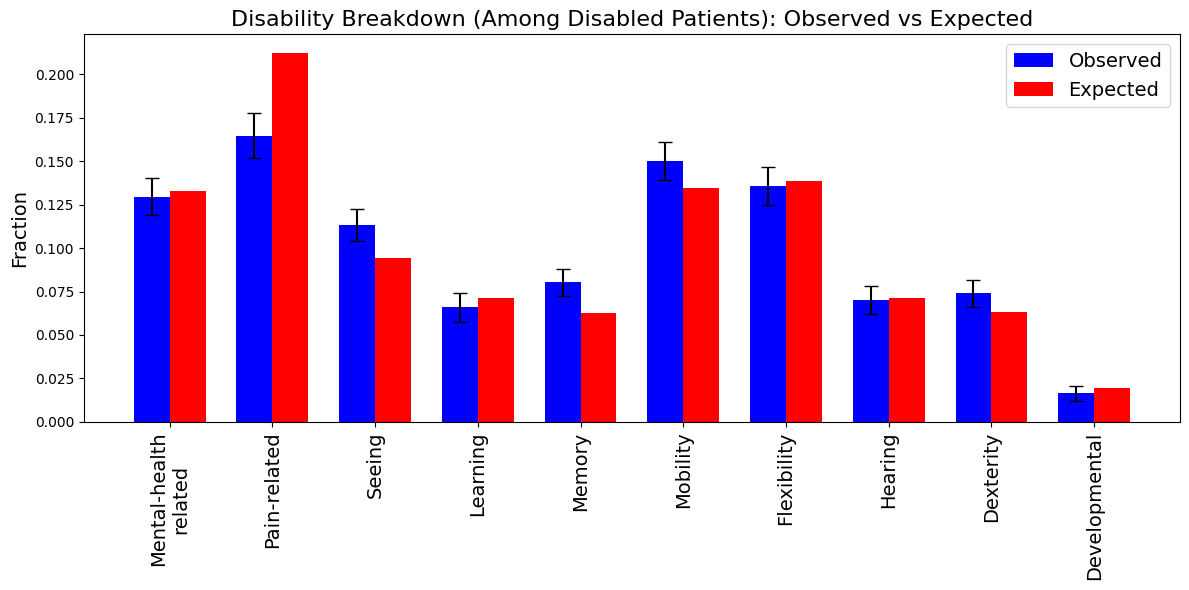

Saved: plots/comparison_of_sex_distribution.png


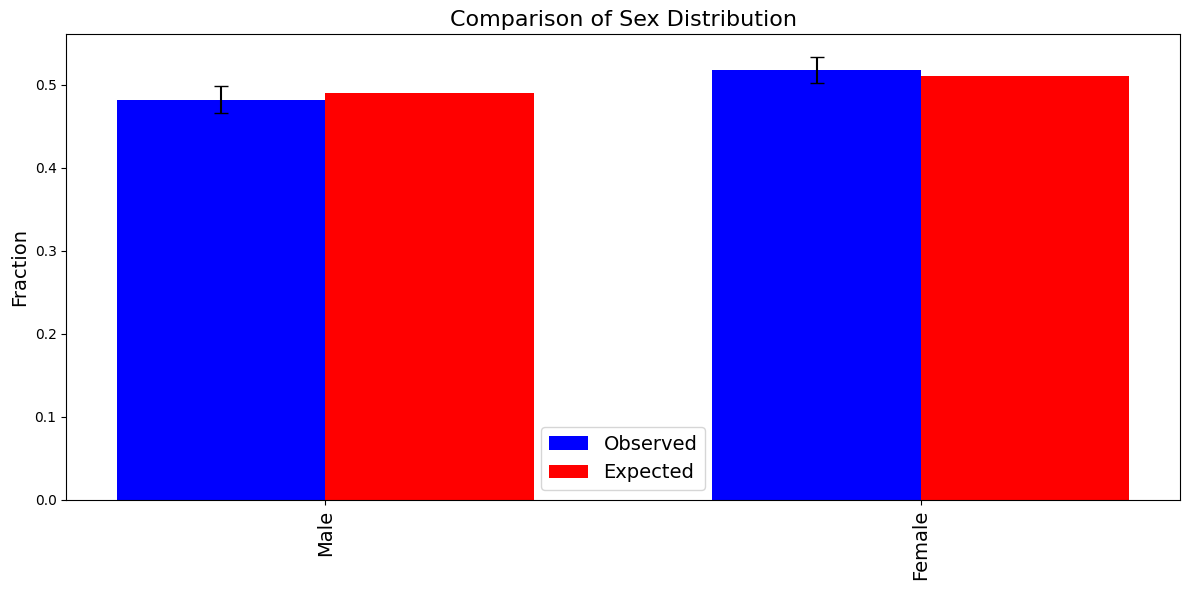

Saved: plots/comparison_of_age_distribution_(observed_vs._expected).png


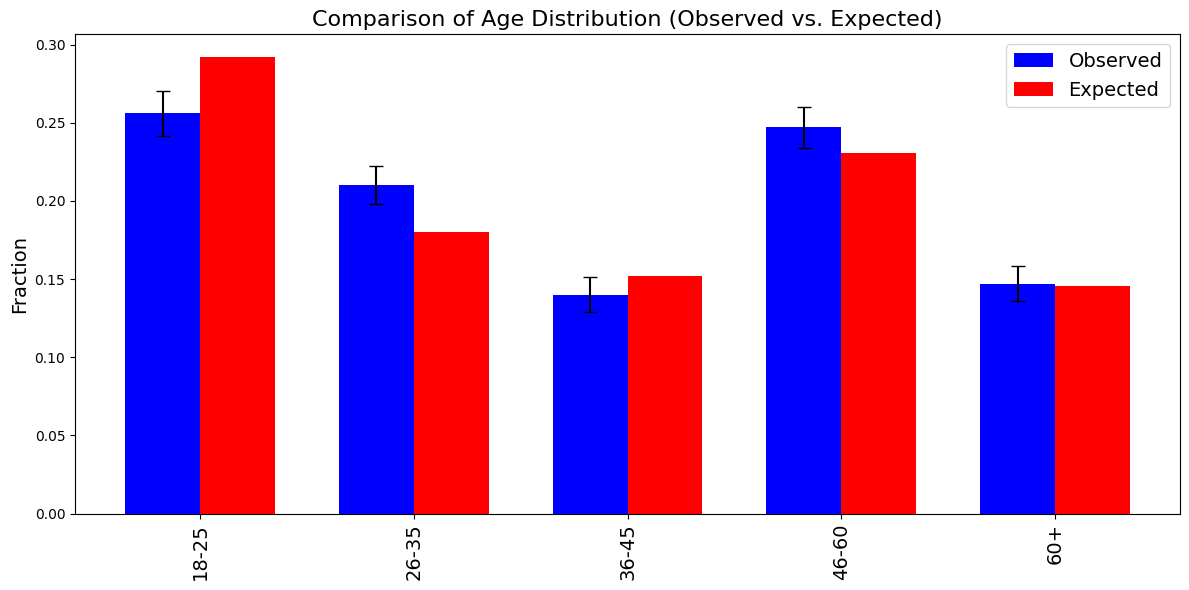

Saved: plots/combined_relationship_status.png


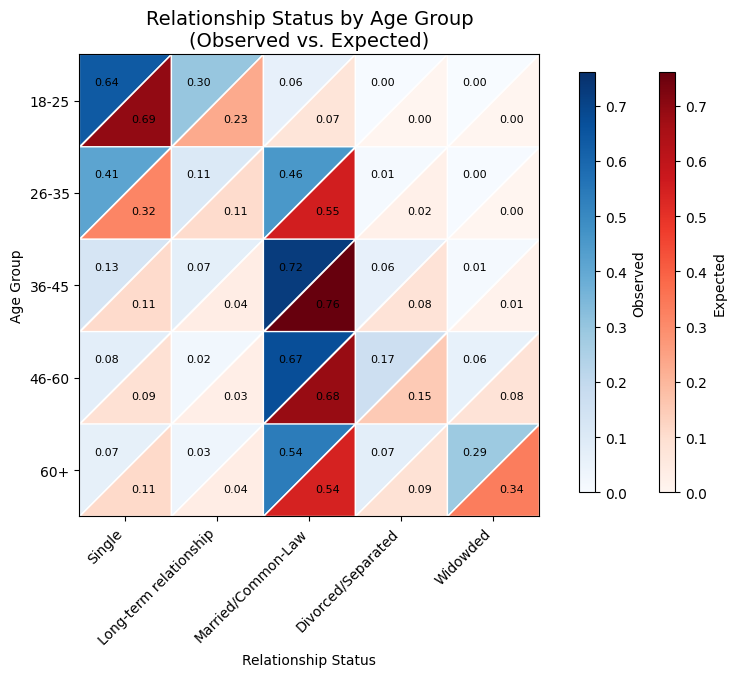

/tmp/ipykernel_1447507/2232773218.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_for_children.groupby(['Age_Group', 'Sex'])['Has_Children']


Saved: plots/combined_children_by_age_sex.png


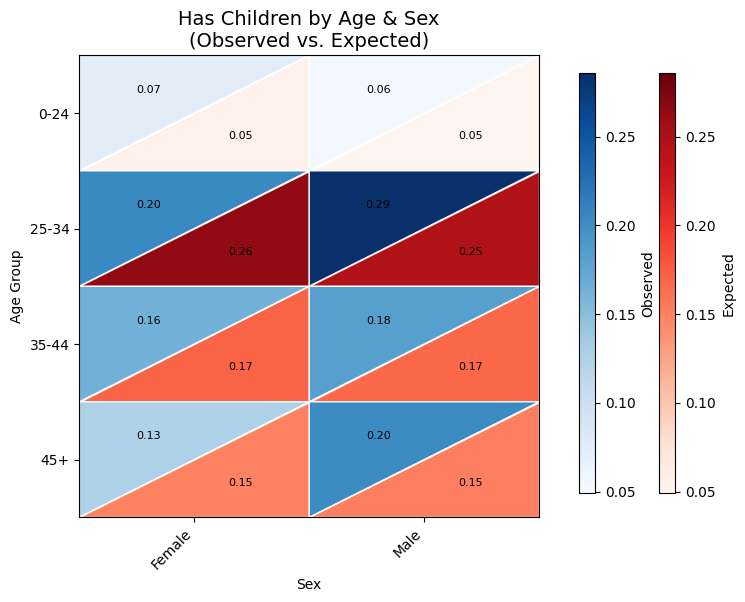

In [9]:
def main():
    """Main: load data, preprocess, then run the analysis flow."""
    file_path = "llm_patients_040725.csv"
    df = load_data(file_path)
    df = preprocess_data(df)
    run_analysis(df)


if __name__ == "__main__":
    main()